<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 Combined: West Nile Virus Prediction

--- 
# Contents


---

### Contents:
Notebook 1

--- 
# Modelling


---

In [3]:
# import libraries

# maths
import numpy as np
import pandas as pd
import scipy.stats as stats
from pandas.api.types import is_numeric_dtype

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder

from scipy.stats import ttest_ind

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import matthews_corrcoef, plot_confusion_matrix,accuracy_score,plot_roc_curve,auc, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
#regularizing gradient boosting
from xgboost import XGBClassifier, XGBRFClassifier 

from ipywidgets import IntSlider, interact

import warnings
warnings.filterwarnings('ignore')

In [4]:
#load CSV files
train= pd.read_csv('../datasets/df_train.csv')
test= pd.read_csv('../datasets/df_test.csv')

In [5]:
# One hot encoding columns
one_hot_encoding_columns = ['Species', 'Trap']
train2 = pd.get_dummies(train,columns=one_hot_encoding_columns)

In [6]:
#change date type from object to datetime64[ns]
train2['Date'] = pd.to_datetime(train2['Date'])

In [7]:
#it wouldnt run later due to types, set date as index
train2.set_index('Date',inplace=True)

# Train model

In [8]:
# Set X and y
X = train2.drop('WnvPresent', axis =1)
y = train2['WnvPresent']

#baseline accuracy before smote
y.value_counts(normalize=True)
#after smote, baseline accuracy would be 0.5

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

In [9]:
#train test split
#test size set at 20%

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, stratify=y,test_size=0.2)
X_train.shape, X_test.shape

((6780, 166), (1695, 166))

In [10]:
#Standard scaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [11]:
#constructing 4 pipeline
# pipe line 1, smote with Randomforestclassifier
# SMOTE synthesises new minority instances between existing minority instances
# SMOTE applies KNN approach where it selects K nearest neighbors, joins them and creates the synthetic samples in the space.
# RandomForestClassifier fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
pipe_1 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=15)), 
                   ('RF', RandomForestClassifier(random_state=42))])
# pipe line 2, smote with XGBClassifier
#XGBClassifier is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library
pipe_2 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=10)), 
                   ('xgb', XGBClassifier(n_estimators=200,learning_rate=0.3))])
# pipe line 3, smote with AdaBoostClassifier
# AdaBoostClassifier begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases
pipe_3 = Pipeline([('sampling', SMOTE(random_state=42)),
                   ('ada', AdaBoostClassifier())])
#logistic regression
pipe_4 = Pipeline([('sampling', SMOTE(random_state=42)),
                   ('logr', LogisticRegression())])

#function to run pipeline with GridSearchCV
def run_model(pipe, pipe_params):
    
    global X_train_ss,X_test_ss,y_train,y_test
    
    #include gridsearch
    gs = GridSearchCV(pipe,param_grid = pipe_params,scoring = 'roc_auc', cv=5, verbose = 1, n_jobs = -1)
    gs.fit(X_train_ss,y_train)
    print(gs.best_params_)
    preds = gs.predict(X_test_ss)
    print("MCC score: ", matthews_corrcoef(y_test,preds))
    print("Accuracy score: ", gs.score(X_test_ss,y_test))
    plot_confusion_matrix(gs,X_test_ss,y_test)
    plot_roc_curve(gs,X_test_ss,y_test)

#function to run pipeline with RandomizedSearchCV
#RandomizedSearchCV the model selects the combinations randomly
def run_model2(pipe, pipe_params):
    
    global X_train_ss,X_test_ss,y_train,y_test
    
    #include gridsearch
    gs = RandomizedSearchCV(pipe, param_distributions=pipe_params, scoring = 'roc_auc', random_state=42, cv=5, verbose = 1, n_jobs = -1)
    gs.fit(X_train_ss,y_train)
    print(gs.best_params_)
    preds = gs.predict(X_test_ss)
    print("MCC score: ", matthews_corrcoef(y_test,preds))
    print("Accuracy score: ", gs.score(X_test_ss,y_test))
    plot_confusion_matrix(gs,X_test_ss,y_test)
    plot_roc_curve(gs,X_test_ss,y_test)
    
    
pipe_params_1 = {'sampling__k_neighbors': [10, 15,20], 
                 'RF__n_estimators': [10, 20, 30], 
                 'RF__max_leaf_nodes': [3, 4, 5],
                 'RF__max_depth': [3, 4, 5]}

pipe_params_2 = {'sampling__k_neighbors': [5, 10],
                 'xgb__n_estimators': [20, 50,], 
                 'xgb__learning_rate': [0.03, 0.05,],
                 'xgb__max_depth':[3, 4],
                 'xgb__n_estimators': [30, 40],
                 'xgb__subsample':[0.8, 1],
                 'xgb__verbosity': [0,2]}

pipe_params_3 = {'sampling__k_neighbors': [5,10,15], 
                 'ada__n_estimators': [20, 40, 60],
                 'ada__learning_rate': [0.9, 1]}

pipe_params_4 = {'sampling__k_neighbors': [5,10,15], 
                 'logr__penalty': ['l1', 'l2'],
                 'logr__C':np.logspace(-4,4),
                 'logr__class_weight': [None, 'balanced']}


Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'RF__max_depth': 4, 'RF__max_leaf_nodes': 5, 'RF__n_estimators': 30, 'sampling__k_neighbors': 15}
MCC score:  0.2874887835033479
Accuracy score:  0.8486647392507742


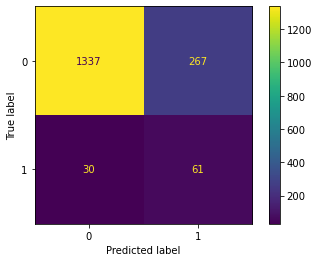

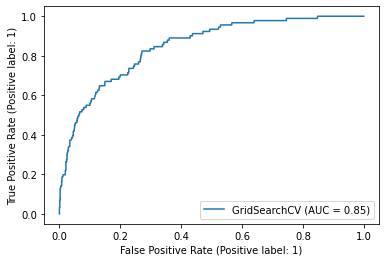

In [41]:
run_model(pipe_1, pipe_params_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'sampling__k_neighbors': 15, 'RF__n_estimators': 30, 'RF__max_leaf_nodes': 4, 'RF__max_depth': 5}
MCC score:  0.2899827550478548
Accuracy score:  0.8395803074730755


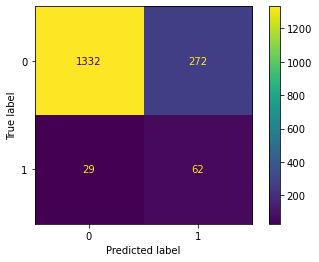

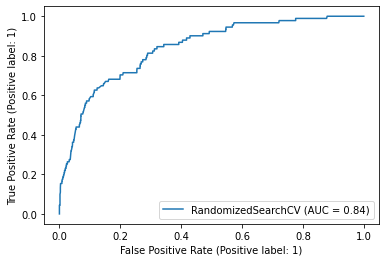

In [42]:
run_model2(pipe_1, pipe_params_1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'sampling__k_neighbors': 10, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__n_estimators': 40, 'xgb__subsample': 0.8, 'xgb__verbosity': 0}
MCC score:  0.3502222833521057
Accuracy score:  0.8771101093420296


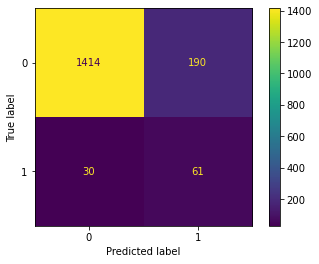

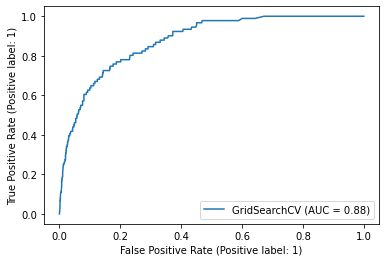

In [12]:
run_model(pipe_2, pipe_params_2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[17:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[17:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tr

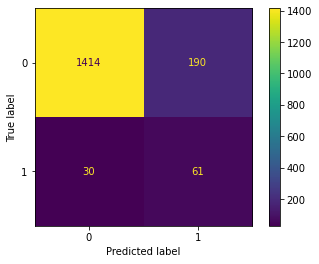

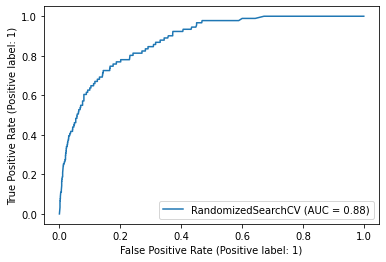

In [13]:
run_model2(pipe_2, pipe_params_2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'ada__learning_rate': 1, 'ada__n_estimators': 40, 'sampling__k_neighbors': 5}
MCC score:  0.3538360776302876
Accuracy score:  0.8716430078649531


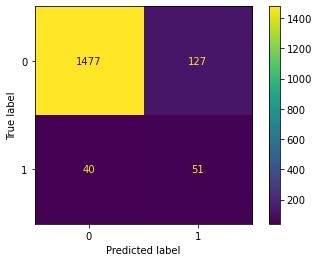

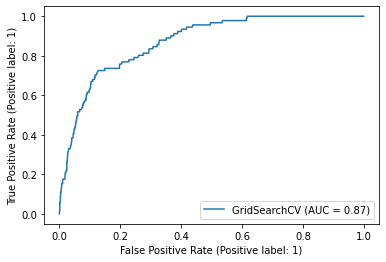

In [14]:
run_model(pipe_3, pipe_params_3)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'sampling__k_neighbors': 5, 'ada__n_estimators': 40, 'ada__learning_rate': 0.9}
MCC score:  0.365481953026294
Accuracy score:  0.8779185278561837


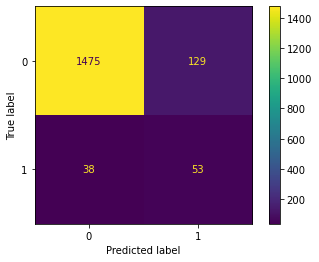

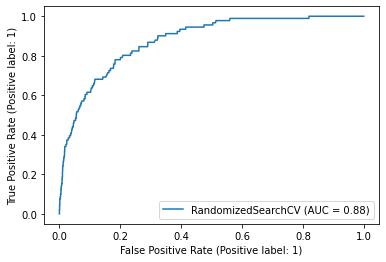

In [15]:
run_model2(pipe_3, pipe_params_3)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
{'logr__C': 0.040949150623804234, 'logr__class_weight': None, 'logr__penalty': 'l2', 'sampling__k_neighbors': 5}
MCC score:  0.21087066885196729
Accuracy score:  0.7879682661478173


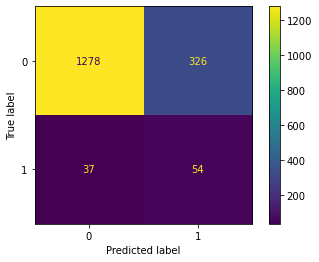

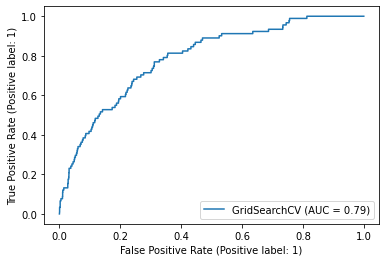

In [16]:
run_model(pipe_4, pipe_params_4)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'sampling__k_neighbors': 15, 'logr__penalty': 'l2', 'logr__class_weight': None, 'logr__C': 0.0009540954763499944}
MCC score:  0.19781928525792927
Accuracy score:  0.800067139842701


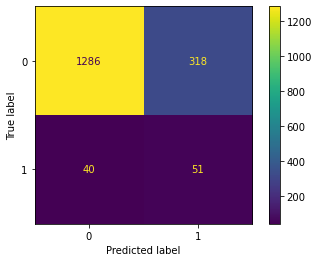

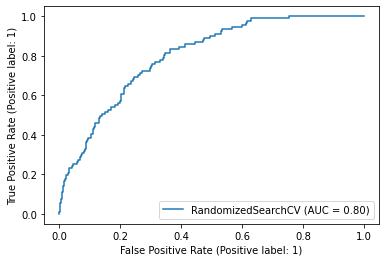

In [17]:
run_model2(pipe_4, pipe_params_4)

# Test data manipulation

In [19]:
#convert date format
test['Date'] = pd.to_datetime(test['Date'])

In [20]:
# One hot encoding species
test2 = pd.get_dummies(test,columns=['Species'])

In [21]:
testmod = test2.columns.tolist()
testmod.remove('Id')

In [22]:
#seeing difference between train and test data
set_a = set(testmod)
set_b = set(train2.columns)

#in test but not in train set
print(set_a.difference(set_b))
print(' ')
#in train set but not in test set
print(set_b.difference(set_a))

#put differences of column features of, (in test but not in train) into a variable 'list_a'
list_a = list(set_a.difference(set_b))
list_b = list(set_b.difference(set_a))

{'Date', 'Street', 'Species_UNSPECIFIED CULEX', 'Trap', 'AddressNumberAndStreet', 'Address'}
 
{'Trap_T155', 'Trap_T235', 'Trap_T065', 'Trap_T071', 'Trap_T012', 'Trap_T003', 'Trap_T044', 'Trap_T900', 'Trap_T128', 'Trap_T146', 'Trap_T034', 'Trap_T212', 'Trap_T144', 'Trap_T100', 'Trap_T011', 'Trap_T031', 'Trap_T007', 'Trap_T073', 'Trap_T153', 'Trap_T230', 'Trap_T228', 'Trap_T060', 'Trap_T072', 'Trap_T095', 'Trap_T147', 'NumMosquitos', 'Trap_T004', 'Trap_T096', 'Trap_T019', 'Trap_T008', 'Trap_T015', 'Trap_T070', 'Trap_T047', 'Trap_T084', 'Trap_T099', 'Trap_T222', 'Trap_T226', 'Trap_T238', 'Trap_T043', 'Trap_T039', 'Trap_T066', 'Trap_T037', 'Trap_T009', 'Trap_T061', 'Trap_T160', 'Trap_T013', 'Trap_T082', 'Trap_T157', 'Trap_T018', 'Trap_T115', 'Trap_T148', 'Trap_T138', 'Trap_T206', 'Trap_T151', 'Trap_T231', 'Trap_T221', 'Trap_T001', 'Trap_T224', 'Trap_T076', 'Trap_T225', 'Trap_T045', 'Trap_T081', 'Trap_T036', 'Trap_T156', 'Year', 'Trap_T014', 'Trap_T077', 'Trap_T085', 'Trap_T062', 'Trap_T15

In [23]:
#test drop columns that are not in train set
test2.drop(columns = list_a, inplace = True, errors = 'ignore')

#fill nan to 0 in test 
test2.fillna(0, inplace = True)

In [24]:
#fill 0 values for columns not present in test data
for n in list_b:
    test2[n] = 0

In [25]:
test2.drop ('Unnamed: 0',axis =1, inplace = True)

In [26]:
test2.shape

(116293, 167)

In [27]:
train2.shape

(8475, 167)

In [28]:
X = train2.drop('WnvPresent', axis =1)
y = train2['WnvPresent']
X_test = test2.drop('Id', axis =1)

# Model RandomForest

In [29]:
#best parameters
kneighbestparam = 15
n_estimatorsbestparam = 30
max_leaf_nodesbestparam = 5

In [30]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=kneighbestparam)), 
                    ('RF', RandomForestClassifier(n_estimators=n_estimatorsbestparam, max_leaf_nodes = max_leaf_nodesbestparam))])

best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)[:,1]

In [31]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']

In [32]:
testing_submission.to_csv('../datasets/model1submission.csv', index=False)

# Model ADAboost

In [33]:
#best parameters
kneighbestparam2 = 5
learning_ratebestparam2 = 1
n_estimatorsbestparam2 = 40

In [34]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=kneighbestparam2)),
                   ('ada', AdaBoostClassifier(learning_rate = learning_ratebestparam2, n_estimators = n_estimatorsbestparam2))])


best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)[:,1]

In [35]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']
testing_submission.to_csv('../datasets/model2submission.csv', index=False)

# Model XGBoost

In [41]:
#best parameters
kneighbestparam3 = 10
learning_ratebestparam3 = 0.05
max_depthbestparam3 = 4
n_estimatorsbestparam3 = 40
subsample_bestparam3 = 0.8
verbosity_bestparam3 = 0

In [48]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=kneighbestparam3)), 
                    ('xgb', XGBClassifier(learning_rate  = learning_ratebestparam3, max_depth = max_depthbestparam3, 
                                          n_estimators = n_estimatorsbestparam3, subsample = subsample_bestparam3,
                                          verbosity = verbosity_bestparam3))])


best_gs.fit(X, y)

test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']
testing_submission.to_csv('../datasets/model4submission.csv', index=False)
predictions = best_gs.predict_proba(X_test)[:,1]

In [49]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']
testing_submission.to_csv('../datasets/model3submission.csv', index=False)

# Model Logistic Regression

In [50]:
#best parameters
kneighbestparam4 = 5
penaltybestparam4 = 'l2'
class_weightbestparam4 = None
Cbestparam4 = 0.040949150623804234

In [51]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=kneighbestparam4)), 
                    ('logr', LogisticRegression(penalty  = penaltybestparam4, class_weight = class_weightbestparam4, 
                                          C = Cbestparam4))])

best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)

In [52]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']
testing_submission.to_csv('../datasets/model4submission.csv', index=False)